# Univariate Analysis of NMR Data

In this notebook we will perform a *univariate* analysis of 4 racks from the NMR profiling dataset of the *Dementia research cohort*, as an alternative to the mulivariate PLS-DA analysis. For details of the study see the Metabolights Study [MTBLS719](https://www.ebi.ac.uk/metabolights/MTBLS719).

This analysis is comprised of the following steps:

1) For each signal in a given chemical shift position (ppm) we fit a linear regression model explaining variance in signal intensity based on a set of fixed covariates (age and gender). This model will be used to test for significant differences in signal intensity due between genotypes.

2) After obtaining the *p-values* and regression coefficient estimates from step 1), multiple testing correction is applied to control the number of false positives.

3) As an extra step to assess robustness of findings, we also perform bootstrap resampling of the models fitted in 1).

4) Visualization of the regions of the spectrum associated with each covariate of interest.

In this examples we use linear regression to fit a model and then perform statistical hypothesis tests, but these analyses can be performed also by using *t-tests*, one-way and two-way ANOVA models directly, or even their non-parametric equivalent.

## Package import and environment setup

Import all the packages and configure notebook plotting mode.

In [ ]:
!pip install -q ipympl

In [ ]:
!git clone https://github.com/IPTC-DataAnalysisCourse/chemometrics-tutorials.git
%cd chemometrics-tutorials

In [2]:
# Import the required python packages including 
# the custom Chemometric Model objects
import numpy as np
from sklearn import preprocessing
import pandas as pds
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colormaps
import statsmodels.formula.api as smf
import numpy as np

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from statsmodels.stats.multitest import multipletests

# The custom Chemometric Model objects for plotting
from pyChemometrics.plotting_utils import manhattan_plot, interactive_manhattan
from pyChemometrics.plotting_utils import _scatterplots as scatterplot
from pyChemometrics.plotting_utils import _lineplots as Lineplot

The next cell sets up the figure display mode. The *notebook* and *ipympl* modes allows interactive plotting. Another option is to select *inline*, to obtain static plots in a notebook cell.

In [3]:
# Set the plot backend to support interactive plotting
%matplotlib notebook # run this line when running in jupyter notebook

In [ ]:
# Set the plot backend to support interactive plotting - Run this when running in Google Colab
%matplotlib ipympl

import plotly.io as pio
pio.renderers.default = "colab"

from google.colab import output
output.enable_custom_widget_manager()

## Data Import

We will now import the NMR data and the metadata (Y variables).

X - NMR data matrix

Y - Matrix with the 2 metadata outcomes

ppm - Chemical shift axis for the NMR data in H $\delta$ppm.

#### Metadata
Y1 - represents the sex (1: Male, 0: Female, in original Y data matrix)

Y2 - represents the age (varies from 61 - 94, in original Y data matrix)

In [4]:
# Load the dataset
dementia_nmr_dataset = pds.read_csv("./Data/Dementia U NMR_PQN_normalised_Data.csv",delimiter=',')

# Delete samples where outcome variable is unknown - Study Samples in standard NPC pipeline
dementia_nmr_dataset = dementia_nmr_dataset[~dementia_nmr_dataset['Gender'].isnull()]

# Create the X matrix
X = dementia_nmr_dataset.iloc[:, 5::].values

# Use pandas Categorical type to generate the dummy enconding of the Y1 vector (0 and 1) 
Y1 = pds.Categorical(dementia_nmr_dataset['Gender']).codes

#Use any regular numpy array for continuous variables
Y2 = np.array(dementia_nmr_dataset['Age'], dtype='int')

ppm = np.array(dementia_nmr_dataset.columns[5::], dtype=np.float64)

**Note**: To apply the analyses exemplified in this notebook to any other dataset, just modify the cell above to import the data matrices and vectors X and Y from any other source file.

The expected data types and formatting for **X** and **Y** are:

   **X**: Any data matrix with n rows (observations/samples) and p columns (variables/features). The matrix should be provided as a [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with 2 dimensions, and with shape = (n, p). We recommend using the *numpy* function [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html) or the *pandas* [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data from a text file. When using the *pandas.read_csv* function, extract the data matrix as a *numpy.ndarray* from the pandas.DataFrame object using the `.values` attribute. 
```
X_DataFrame = pds.read_csv("./data/X_spectra.csv")
X = X_DataFrame.values
```
   
   **Y** vectors: Each **Y** vector should be a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with a number and ordering of elements matching the rows in **X**. For continuous variables, any regular *numpy.ndarray* with a data type of `int` (integers only) or `float` can be used.
   ```
   Y_continuous = numpy.ndarray([23.4, 24, 0.3, -1.23], dtype='float')
   ```
To encode binary class labels, a *numpy.ndarray* of dtype `int`, with 0 and 1 as labels (e.g., 0 = Control, 1 = Case) must be used. The way in which classes are encoded will affect the model interpretation: the class labeled as 1 is used as the "positive/case" class by the *pyChemometrics* objects.
   
   In the example above, we used the *pandas* [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) datatype to handle the conversion of the original numerical values (1, 2) to the required (0, 1) labels. After converting a column to a `Categorical` datatype, the `.codes` attribute returns a vector with the same length of the original Y, but where each value is replaced by their integer (`int`) code. The correspondence between code and category can be inspected with the `categories` attribute. The order of the labels in `.codes` is the same as the order of the `categories` attribute (i.e. 0 is the first element in `categories`, 1 the second and so on).
   ```
   Y1 = pds.Categorical(Y.iloc[:, 1])
   Y1.codes # The numerical label
   Y1.categories # Original text or numerical description of the category
   ```
   [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) is another helpful function to perform dummy (0-1) encoding of variables. 
   
For the linear regression models, we will also generate a pandas DataFrame contaning the metabolic and class variables. This is done to take advantage of the more explicit `formula` synthax from the *statsmodels* package. 

In [5]:
# Prepare the dataframe for use with model fitting
dataset = pds.DataFrame(data = X, columns = ppm)

# Add the Y vector at the beginning of the dataframe
dataset.insert(0, 'Gender', Y1)
dataset.insert(1, 'Age', Y2)

# Display dataframe
dataset

Gender  Age         10.0  9.999449972498624  9.99889994499725  \
0         1   82   821.514846        1541.861254        953.309093   
1         1   69  1364.530946        1065.229256        635.491772   
2         1   83  -540.364052        -123.181238        870.541889   
3         1   73  2449.927327         855.832273         19.990850   
4         1   72  -255.079425        -137.450395       -155.206521   
..      ...  ...          ...                ...               ...   
280       0   82   945.137043        1220.093654        344.985036   
281       1   77  1225.379364         428.239651        479.571278   
282       1   86   388.907249         656.735878        494.075039   
283       0   78  1022.533563         991.266223        297.282450   
284       1   79  2320.487818        2143.816293       1594.398906   

     9.998349917495874  9.9977998899945  9.997249862493124  9.99669983499175  \
0           768.388669       561.953245         480.515677        555.247358   
1           570.367852        83.973022         937.528738       1172.236382   
2          1512.513529       536.289992         702.776785        113.412391   
3           554.212970       211.743689        1409.197564       2031.574398   
4          1503.023447      1778.292469        -461.603870        152.887127   
..                 ...              ...                ...               ...   
280         697.422757      -191.522887        1409.398100       1342.155253   
281        1519.310568      2578.472435        -533.104420        985.060820   
282         931.015331       626.053226         390.849965        579.432011   
283         247.080802      -165.905836         526.118310        116.479581   
284        2446.518458       544.768000         378.267825        219.141120   

     9.996149807490374  ...  0.2045602280114007  0.2040102005100248  \
0           961.699398  ...          -69.918991         1453.335060   
1          1494.398168  ...         1373.968964         1012.002398   
2          1463.917220  ...          583.557670         1721.744895   
3          1475.478704  ...          855.531009         1107.155734   
4          -629.236846  ...         2108.072236         2746.973825   
..                 ...  ...                 ...                 ...   
280        1350.612699  ...         1369.347715         2101.113356   
281        1681.008902  ...          297.621207          622.408423   
282         469.168248  ...         1110.963010          999.466737   
283         559.314771  ...          208.581488          760.267172   
284         114.015893  ...         2230.693231         2823.762717   

     0.2034601730086507  0.2029101455072748  0.2023601180059007  \
0            975.854264          625.453611          940.528791   
1           1044.740135         1449.483575         1064.386929   
2            614.451832         1482.943908          701.402024   
3            527.031512          329.488417         -180.310176   
4           1483.593902          571.215580         1115.298699   
..                  ...                 ...                 ...   
280          930.248151          427.293264         1368.622855   
281         1070.118376         1769.735260          721.772814   
282          517.264783          798.119066          208.731507   
283         1241.982373          824.177833          558.316600   
284         1119.375450         1032.992877         1698.242557   

     0.2018100905045248  0.2012600630031507  0.2007100355017748  \
0            782.223378         1258.166442          962.591077   
1           1473.109420          739.858159          505.451756   
2            726.713589         1079.411588         1175.294880   
3           -409.274830         1579.256248         1046.401899   
4           1808.772819         2098.820409          888.221508   
..                  ...                 ...                 ...   
280         2240.215256          566.404207         1791.092468   
281      

Plot the spectra in the dataset.

<IPython.core.display.Javascript object>


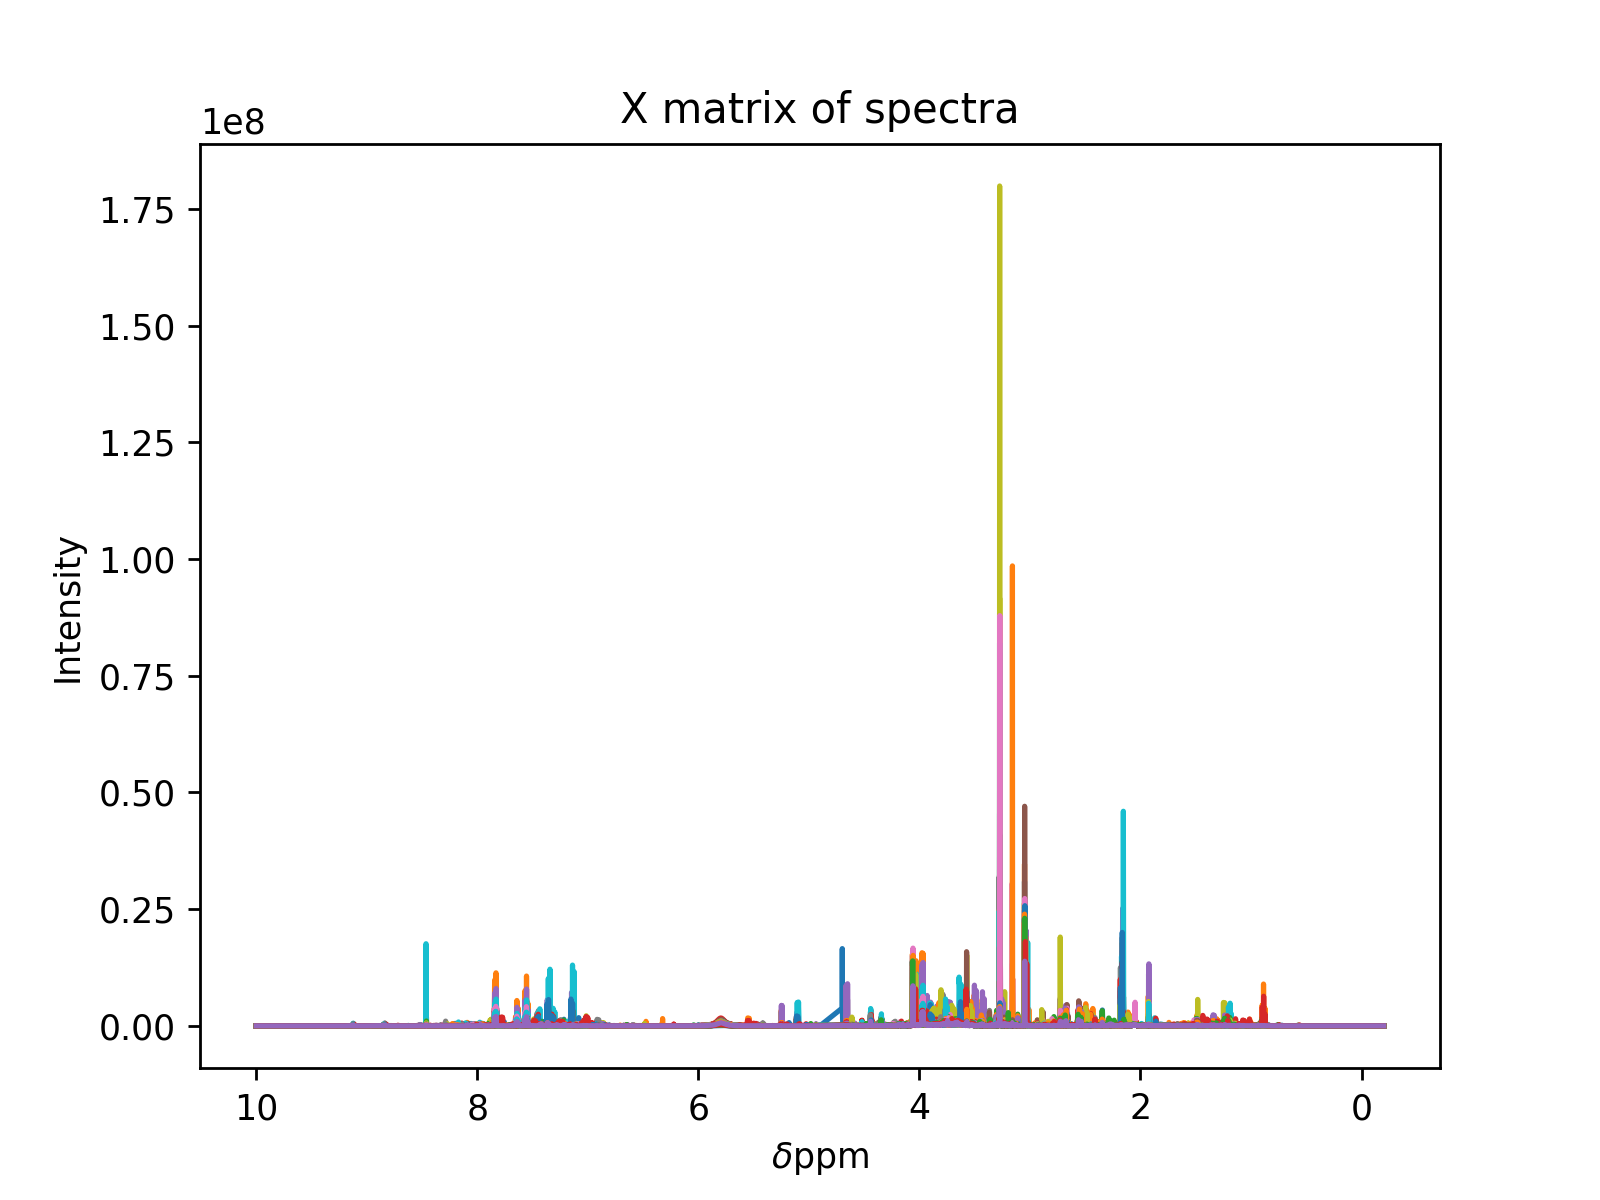

In [6]:
# Plot the dataset
plt.figure()
plt.plot(ppm, X.T)
plt.title("X matrix of spectra")
plt.xlabel("$\delta$ppm")
plt.gca().invert_xaxis()
plt.ylabel("Intensity")
plt.show()

## Linear regression modeling - effect of gender


We start by assessing the effect of genotype on the intensity of each individual spectral signal using linear regression.

This model is equivalent to a 2-sample (each of the genotypes) *t-test* on signal intensity or a 1-way ANOVA with Genotype as a single discrete covariate/factor. Other modelling alternatives are possible, for example, logistic regression.

The results from this model should be comparable with a PLS-DA model regressing the genotype (Y) on the metabolic profile variables (X). Note how the $R^{2}Y$ in the PLS-DA model refers to how well the metabolic profile is able to predict gender, while for the linear models $r^{2}$ measures how much of "metabolite" variability is explained by gender.

In next cell we will iteratively fit the same regression model, Metabolite(y) ~ Gender for each metabolic profile variable (a given point in the chemical shift *x-axis* in $\delta$ppm) value.

For each model, we obtain the calculated $r^{2}$ (variance explained), 
regression coefficients ($\beta$) for each covariate (Gender only for this first model) and the *p-value* of a two-tailed Wald test ($\beta$ significantly different from 0). 

In [7]:
# Lists to store the information
# p-value for the genotype effect
pval_genonly = list()
# regression coefficient for the genotype effect
beta_genonly = list()
# P-value for the F-test 
fpval_genonly = list()
# r2 for the regression model
r2_genonly = list()

# Fit each column with a spectral variable
for curr_variable in dataset.iloc[:, 2:]:
    # Formula for current variable 
    fm = 'Q(curr_variable) ~ C(Gender)'
    mod = smf.ols(formula = fm, data=dataset)
    res = mod.fit()
    pval_genonly.append(res.pvalues[1])
    beta_genonly.append(res.params[1])
    fpval_genonly.append(res.f_pvalue)
    r2_genonly.append(res.rsquared)
    
pval_genonly = np.array(pval_genonly)
beta_genonly = np.array(beta_genonly)
r2_genonly = np.array(r2_genonly)
fpval_genonly = np.array(fpval_genonly)

## Linear modeling per variable - with adjustment for age

Adjustment for other covariates and potential confounders can be easily incorporated in linear regression.
In this case, gender and age will be modelled together. The confounding variation caused by Age will be separated from the effect of genotype. 

In next cell we will iteratively fit the same regression model, Metabolite(y) ~ Gender + Age for each metabolic profile variable (ppm) value. 

For each model, we obtain the calculated $r^{2}$ (variance explained), 
regression coefficients ($\beta$) for each covariate (Gender and Age) and the *p-value* of a two-tailed Wald test ($\beta$ significantly different from 0). 

In [8]:
# Generate lists to store the results for each varable. 


# beta_gen = the values for the regression coefficient associated with age
# pval_gen = the p-value for the t-test
# beta_age = the values for the age regression coefficients 
# pval_age = the p-values for the age regression coefficient 

# r2 = r-squared value for the entire regression model
# fpval = the p-value for the F-test of the model's r-squared

pval_gen = list()
pval_age = list()
beta_gen = list()
beta_age = list()
fpval = list()
r2 = list()

for curr_variable in dataset.iloc[:, 2:]:
    # Fit each column
    fm = 'Q(curr_variable) ~ C(Gender) + C(Age)'
    mod = smf.ols(formula = fm, data=dataset)
    res = mod.fit()
    pval_gen.append(res.pvalues[1])
    pval_age.append(res.pvalues[2])
    beta_gen.append(res.params[1])
    beta_age.append(res.params[2])
    fpval.append(res.f_pvalue)
    r2.append(res.rsquared)
    
pval_gen = np.array(pval_gen)
beta_gen = np.array(beta_gen)
pval_age = np.array(pval_age)
beta_age = np.array(beta_age)
r2 = np.array(r2)
fpval = np.array(fpval)

In [9]:
sum(pval_gen < 0.05)

3989

## Multiple testing correction

One of the problems associated with carrying out a large amount of sequential univariate tests is the potentially high number of false positives. In this instance, we have performed 17456 tests, and at an $\alpha$ threshold of 0.05 the expected number of false positives due to chance alone is equal to $17456~\textrm{(number of tests)} \times 0.05m(\alpha) = 872.8$ ~ $873$

The set of *p-values* obtained by this multiple testing strategy should be corrected to restrict the expected large number of false positives. 

In this example we use the Benjamini-Yekutieli procedure to control the false discovery 
rate (FDR) of the sequential univariate testing procedure, the proportion of "false discoveries" (false positives) in the metabolic signature uncovered (the set of positive results/rejected null hypotheses from the 18910 univariate tests).

Alternatively, Family-Wise error rate (FWER) correction methods, such as the Bonferroni correction can be used. These re-calibrate the significance threshold so that the FWER, the probability of having one or more false positives in the entirety of the analysis, is kept at a nominal $\alpha$ level (typically 0.05). FWER correction methods tend to be more stringent than FDR correction methods, but the concept of False discovery rate control is particularly suited for metabolic profiling analyses, because FDR control methods aims at controlling the general "quality" (proportion of false positives) of the uncovered signatures.

**Note**: When using FWER adjustment, we use the original *p-values* and simply adjust the $\alpha$ significance level to meet the FWER requirements. The Benjamini-Hochberg and Benjamini-Yekutieli adjustment procedures return new quantities, a set of *q-values* (one per original *p-value*). This new *q-value* should be interpreted in the context of the entire signature, and it specifies the estimated false discovery rate if all features with a *q-value* smaller or equal than the cut-off are selected as hits. For example, setting a 0.05 cut-off implies that the obtained signature has an estimated false discovery rate of 5%.

In [10]:
# Adjusting the first analysis without age
by_res_gen_only = multipletests(pval_genonly, alpha=0.05, method='fdr_by')
p_genonly_byadj = by_res_gen_only[1]

In [11]:
# Adjusting the analysis with gender and age
by_res_gen = multipletests(pval_gen, alpha=0.05, method='fdr_by')
p_gen_byadj = by_res_gen[1]

by_res_f = multipletests(fpval, alpha=0.05, method='fdr_by')
p_byadj_f = by_res_f[1]

by_res_age = multipletests(pval_age, alpha=0.05, method='fdr_by')
p_age_byadj = by_res_age[1]

In [12]:
#Number of significant features
print("Number of features significantly associated with gender")

print("Without adjustment for age: {0}".format(sum(by_res_gen_only[0])))

print("With adjustment for age: {0}".format(sum(by_res_gen[0])))

Number of features significantly associated with gender
Without adjustment for age: 91
With adjustment for age: 80


In [13]:
results_dframe_genonly = pds.DataFrame(np.c_[ppm, pval_genonly, beta_genonly, p_genonly_byadj, r2_genonly, fpval_genonly], 
                               columns=['ppm', 'gender_p-value', 
                                        'gender_beta', 'gender_q-value', 'r2', 'f-test_pval'])
results_dframe_genonly.to_csv('./Data/UnivariateAnalysis_Gender_NMR.csv', index=False)

In [14]:
results_dframe = pds.DataFrame(np.c_[ppm, pval_gen, beta_gen, p_gen_byadj, pval_age, beta_age, p_age_byadj,
                                     r2, fpval], 
                               columns=['ppm', 'gender_p-value', 
                                        'gender_beta', 'gender_q-value', 'age_p-value', 'age_beta', 
                                        'age_q-value', 'r2', 'f-test_pval'])
results_dframe.to_csv('./Data/UnivariateAnalysis_Gender_Age_NMR.csv', index=False)


A histogram of the *p-value* distribution shows a mostly uniform distribution, with a heavy tail at the lower end (towards 0).

<IPython.core.display.Javascript object>


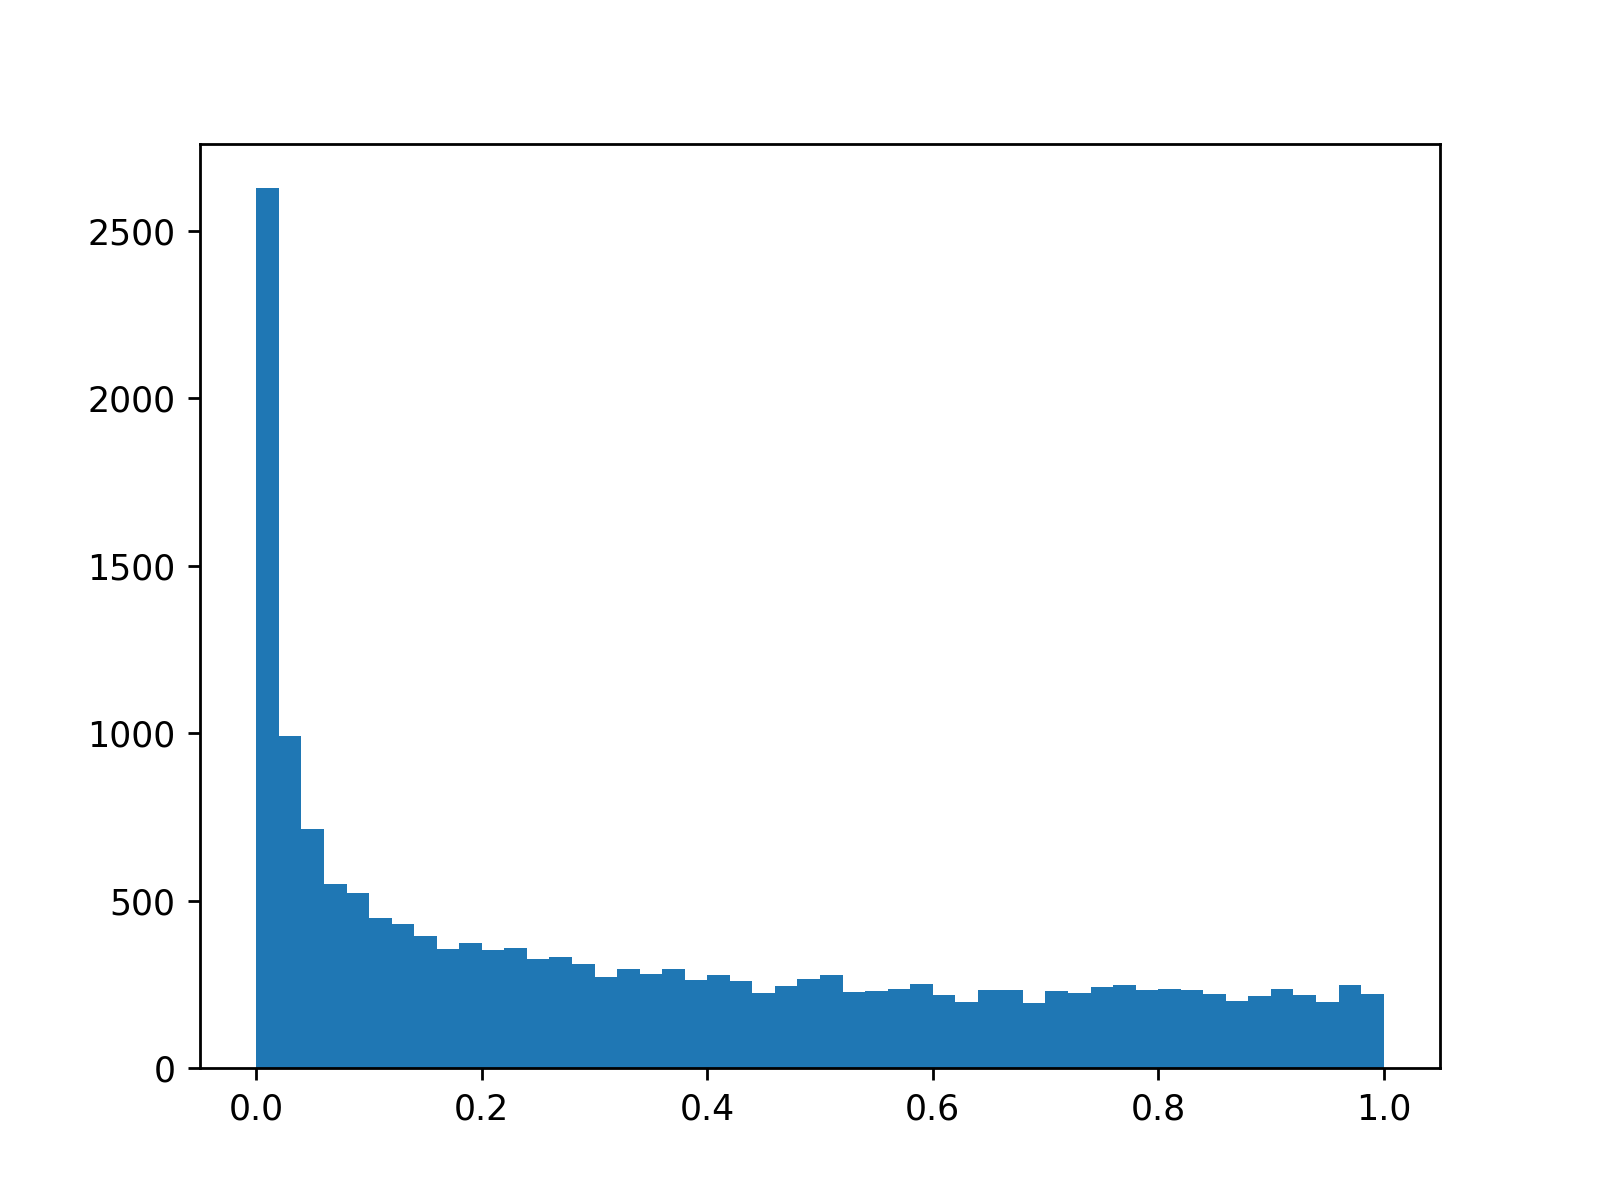

In [15]:
plt.figure()
plt.hist(pval_gen, 50)
plt.show()

Saving the results for comparison with the PLS-DA modelling results. The steps for this comparison are in the **Multivariate analysis with PLS-DA notebook.**

## Model resampling - bootstrapping

In the multivariate modeling steps, cross-validation was used during model validation to obtain uncertainty estimates for the quality of the PLS model and its parameters.

In univariate analysis using linear regression or any other statistical test, jacknifing, bootstrapping and other cross-validation and resampling techniques can also be used to obtain more reliable confidence intervals for model parameters and statistics.

The confidence of the results can be further assessed by observing the bootstrap distribution for *p-values* or test statistics, such as the $\beta$ coefficients.

### Optional: model bootstrapping - Parallel implementation
Non-parametric bootstrapping of cases. Run time is approximately an hour on a PC with 8 cores.

In [ ]:
# Define function that can be called by each worker:
def bootstrap_model(variable, n_boot, dataset):    
    boot_stats = np.zeros((n_boot, 6))
    
    for boot_iter in range(n_boot):
        boot_sample = np.random.choice(dataset.shape[0], dataset.shape[0], replace=True)
        fm = 'Q(dataset.columns[variable]) ~ C(Gender) + C(Age)'
        mod = smf.ols(formula = fm, data=dataset.iloc[boot_sample, :])
        res = mod.fit()
        boot_stats[boot_iter, 0] = res.pvalues[1]
        boot_stats[boot_iter, 1] = res.pvalues[2]
        boot_stats[boot_iter, 2] = res.params[1]
        boot_stats[boot_iter, 3] = res.params[2]
        boot_stats[boot_iter, 4] = res.f_pvalue
        boot_stats[boot_iter, 5] = res.rsquared
    return boot_stats

In [ ]:
# Skip this step if running in Google Colab and load pre-connputed results
import joblib
results = joblib.Parallel(n_jobs=8, verbose=5, pre_dispatch='2*n_jobs')(joblib.delayed(bootstrap_model)(i, 50, dataset) for i in range(2, dataset.shape[1]))
# Save results.
np.save('bootstrap_results_univariate_NMR.npy', results)

In [16]:
#load pre-computed results.
results = np.load('bootstrap_results_univariate_NMR.npy')

In [17]:
# mean and standard deviation for regression coefficients and wald test p-values
# Gender
mean_beta_gen = np.array([x[:, 2].mean() for x in results])
std_beta_gen = np.array([x[:, 2].std() for x in results])
mean_p_gen = np.array([x[:, 0].mean() for x in results])
std_p_gen = np.array([x[:, 0].std() for x in results])
# Age
mean_beta_age = np.array([x[:, 3].mean() for x in results])
std_beta_age = np.array([x[:, 3].std() for x in results])
mean_p_age = np.array([x[:, 1].mean() for x in results])
std_p_age = np.array([x[:, 1].std() for x in results])

# Visualization of results
We can now assess the regression coefficients obtained for each factor and the *p-value* corresponding to the two-tailed Wald t-test of $\beta \neq 0$

<IPython.core.display.Javascript object>


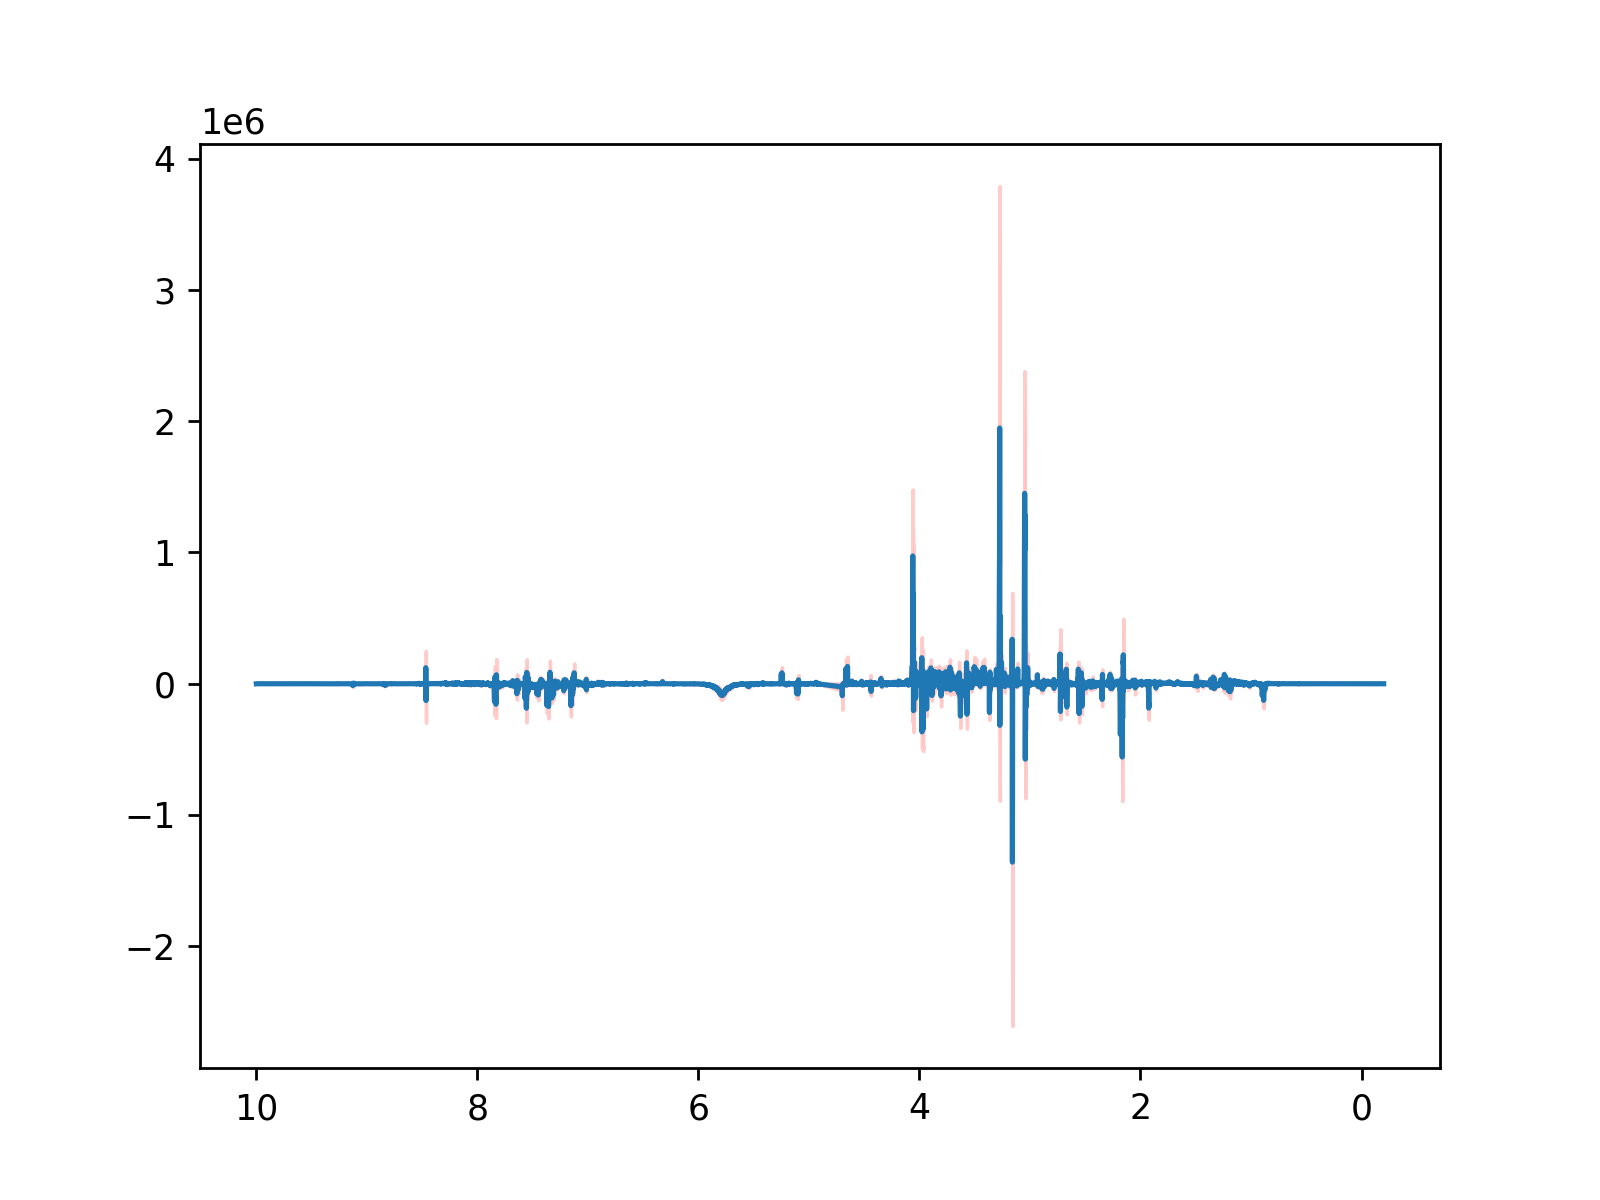

In [19]:
# Visualization of regression coefficients with Bootstrap confidence intervals
Lineplot(mean=mean_beta_gen, error=std_beta_gen, xaxis=ppm)

# Run the following line instead if bootstrapping wasn't done
# Lineplot(mean=beta_gen, error=None, xaxis=ppm)
plt.gca().invert_xaxis()

A Manhattan plot combines the regression coefficient estimate with the magnitude of the *p-value*. The first (estimated $\beta$) is encoded on the colorscale, while the base 10 logarithm of the *p-value* multiplied by the sign of the regression coefficient are plotted in the y axis.

The next figures contain a Manhattan plot style visualization for the effect of the Age covariate...

<IPython.core.display.Javascript object>


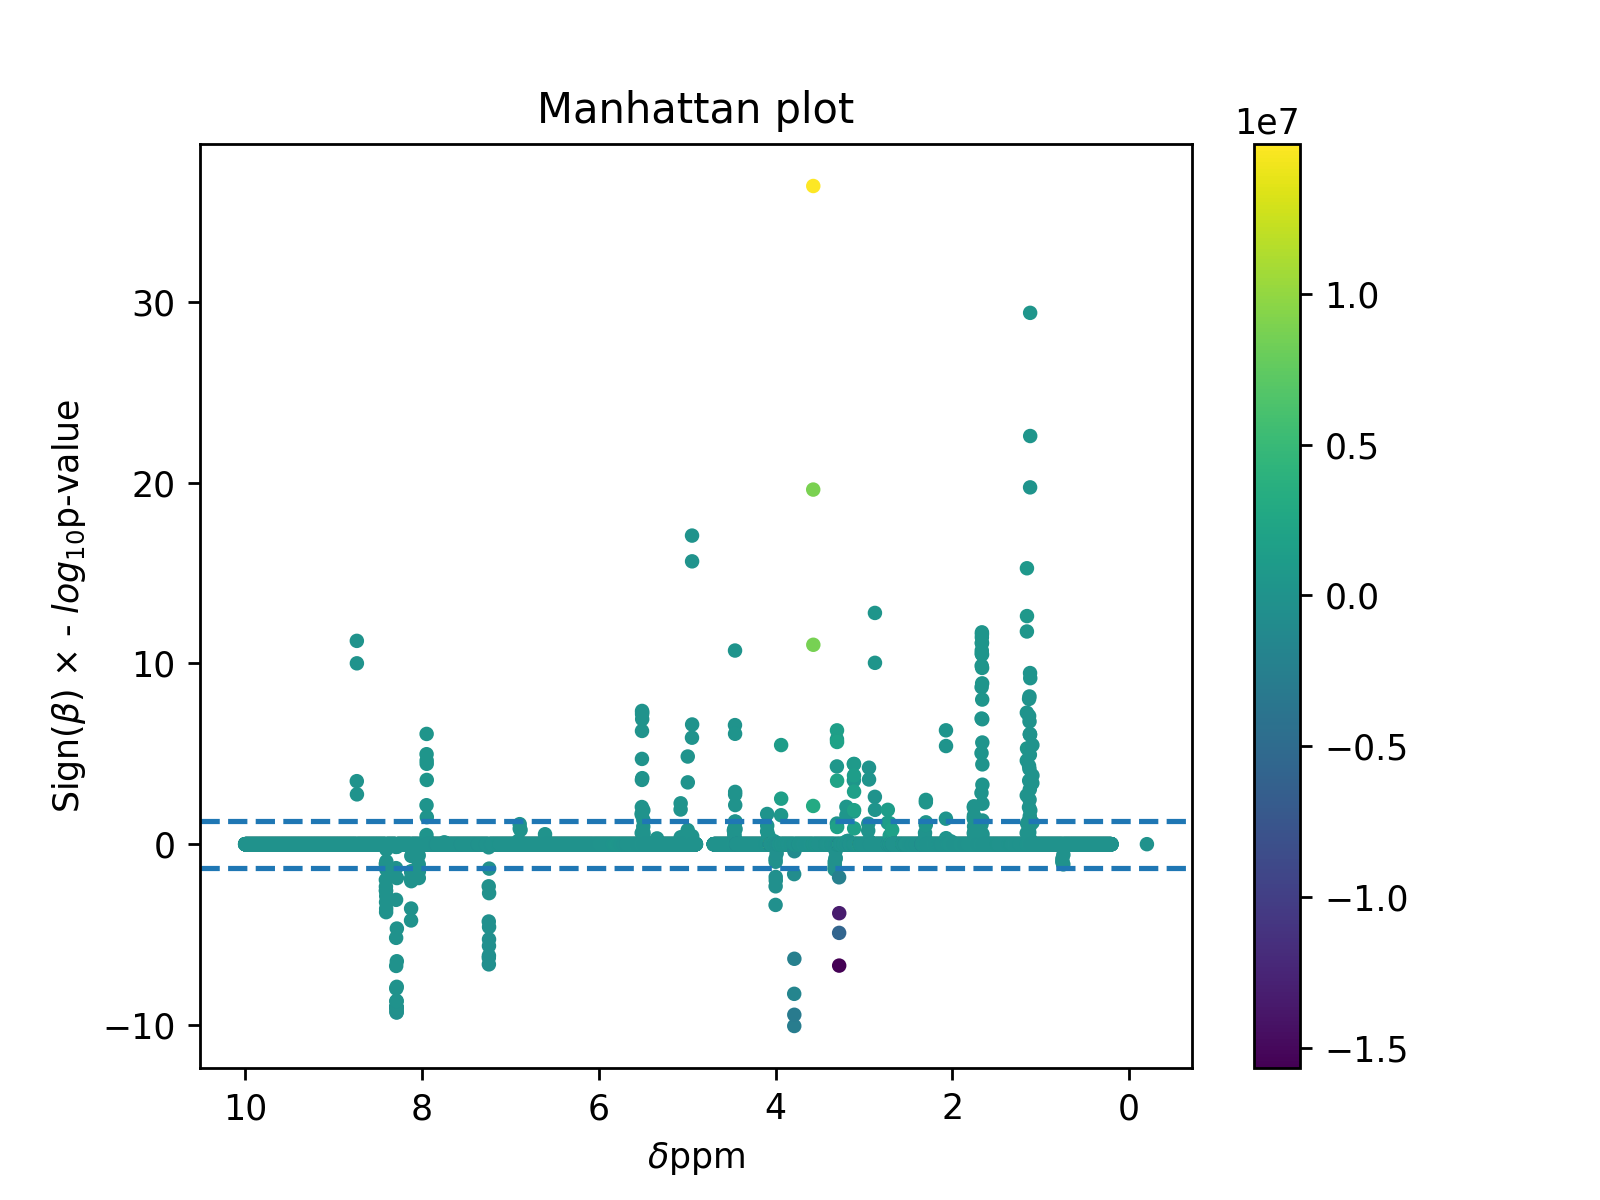

In [20]:
manhattan_plot(p_age_byadj, beta_age, instrument='nmr', xaxis=ppm)

... and for the effect of genotype. 

<IPython.core.display.Javascript object>


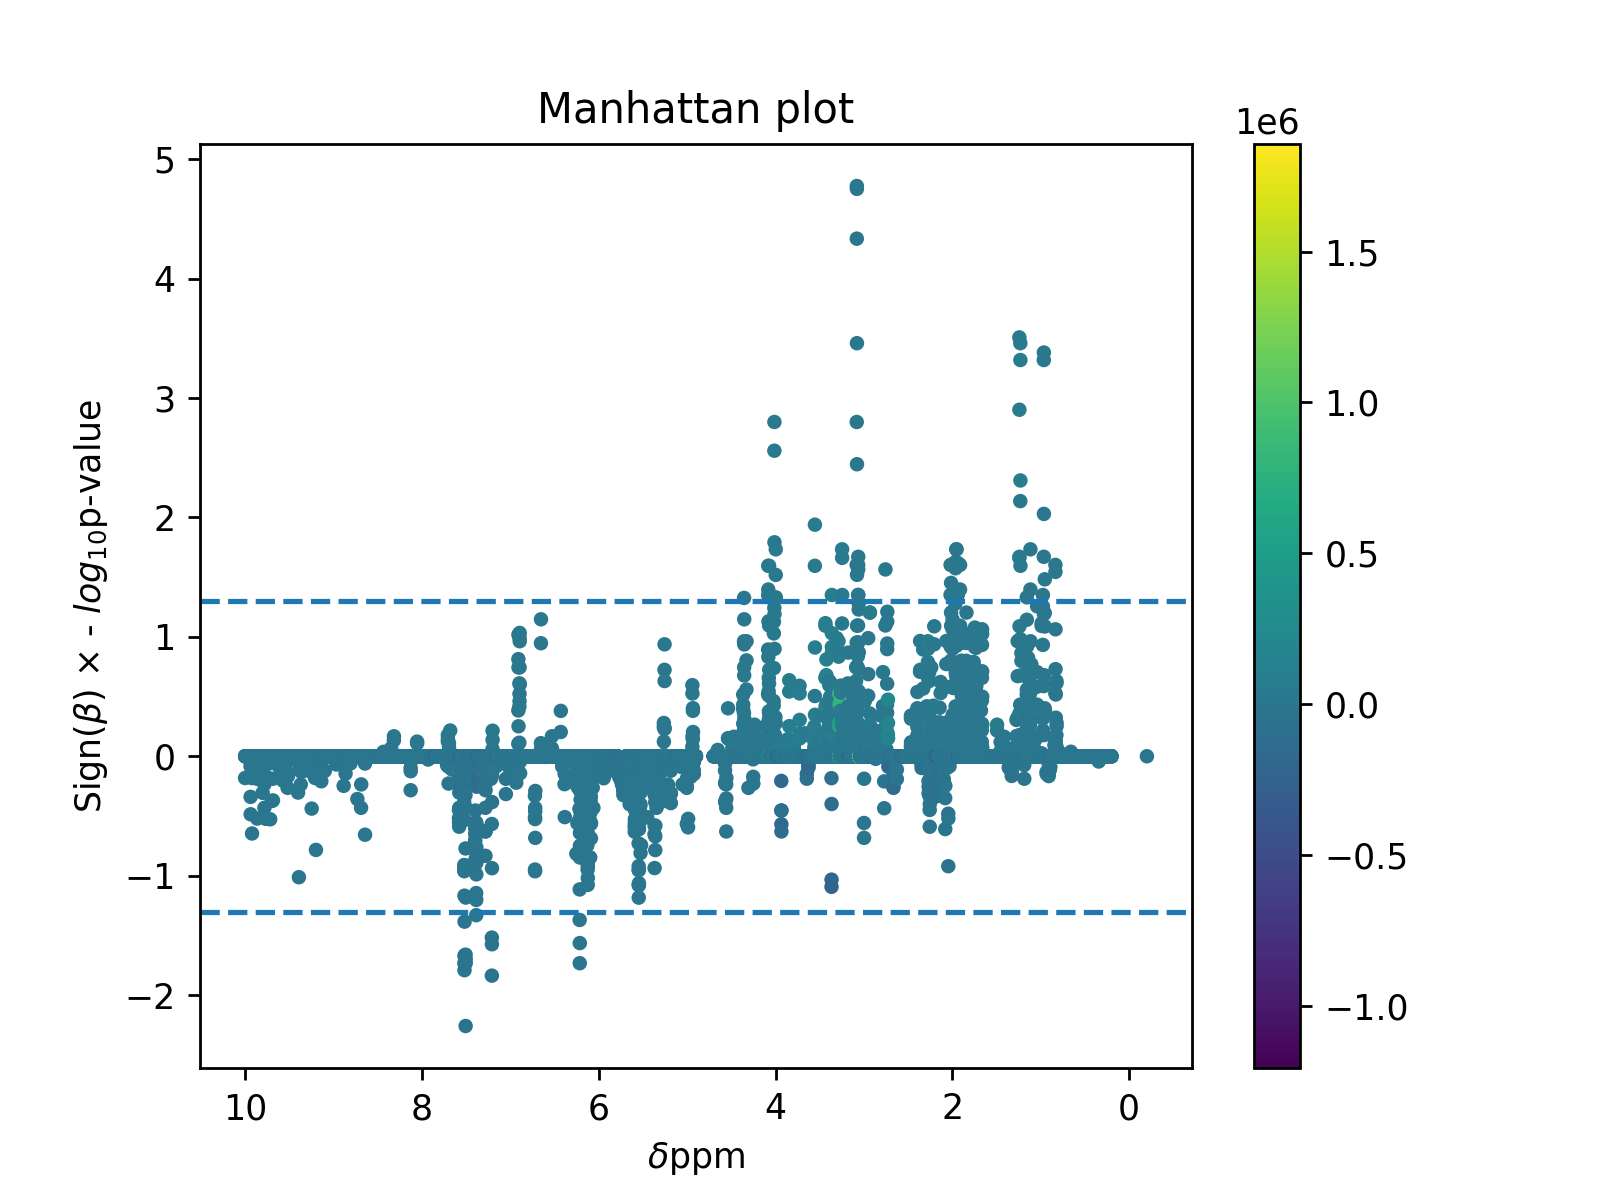

In [21]:
manhattan_plot(p_gen_byadj, beta_gen, instrument = 'nmr', xaxis=ppm)

The **interactive_manhattan** function generates an interactive version of Manhattan Plot, here exemplified for gender and age covariate.

In [22]:
iplot(interactive_manhattan(p_gen_byadj, beta_gen, sig=0.05, instrument = 'nmr', xaxis=ppm))

In [23]:
iplot(interactive_manhattan(p_age_byadj, beta_age, sig=0.05, instrument = 'nmr', xaxis=ppm))